<a href="https://colab.research.google.com/github/hrishi508/Self-and-Semi-Supervised-Learning/blob/main/AlexNet_Barlow_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
# from torchviz import make_dot

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Data Preparation

Here, we are extracting 500 labelled images from the the training set for the self-supervised learning. Using labelled data sounds counter-intuitive but we are not using the labels in the training of the network, we are only using them for the TSNE visualization of the embedding vectors after every epoch.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),   
    
])

training_data = datasets.STL10(
    root="data",
    split="train",
    transform=transform,
    download=False
)

# test_data = datasets.STL10(
#     root="data",
#     split='test',
#     transform=transform,
#     download=False
# )

# unlabelled = datasets.STL10(
#     root="data",
#     split="unlabeled",
#     transform=transform,
#     download=False
# )

In [ ]:
labelled_500, _ = torch.utils.data.random_split(training_data, [500, 4500])

In [ ]:
def imshow(imgt):
    img = imgt.clone()
    t1 = torch.tensor([0.485, 0.456, 0.406])
    t2 = torch.tensor([0.229, 0.224, 0.225])
    img[0]*=t2[0]
    img[1]*=t2[1]
    img[2]*=t2[2]

    img[0]+=t1[0]
    img[1]+=t1[1]
    img[2]+=t1[2]

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
labels_map = {
    0: "airplane",
    1: "bird",
    2: "car",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "horse",
    7: "monkey",
    8: "ship",
    9: "truck",
}
img, label = training_data[155]
print(labels_map[label])
print(img.shape)
imshow(img)

In [ ]:
## HYPERPARAMETERS
BATCH_SIZE = 64  #64
LR = 0.001      #0.001
EPOCHS = 50

train_dataloader = DataLoader(labelled_500, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
# tf = train_features.unsqueeze(0)
# print(tf.shape)
# print(train_labels)
img = train_features[0]
imshow(img)

## Data Augmentation

We have defined several augmentations, with the hyperparameters taken from the original Work on Barlow Twins.

In [ ]:
def augment(x):
    t = transforms.RandomApply([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(15),
        transforms.GaussianBlur(9, sigma=(0.1, 2.0)),
        transforms.RandomSolarize(0.5, 0.2),
        transforms.ColorJitter(0.4, 0.4, 0.2, 0.1) 
    ], p=0.7)

    im1 = t(x)
    im2 = t(x)

    return im1, im2
    # return x.clone(), x.clone()


In [ ]:
a, b = augment(img)
imshow(a)
imshow(b)

# Train function
This function contains our implementaion of the training pseudocode as given in the paper on Barlow Twins.

In [ ]:
def loss_fn(C, lambd):
    loss = 0
    temp = (C - torch.eye(C.size(0), requires_grad=False).to(device)).pow(2)
    temp2 = temp * ((torch.ones(C.shape, requires_grad=False)-torch.eye(C.size(0), requires_grad=False))*lambd).to(device)
    loss = torch.sum(temp2)
    return loss

In [ ]:
def train_model(model, dataloader, loss_func, optimizer, lambd, num_epochs=100):
    since = time.time()
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()

        running_loss = 0.0

        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            optimizer.zero_grad()

            ix1, ix2 = augment(inputs)                     
            x1 = torch.squeeze(model(ix1))
            x2 = torch.squeeze(model(ix2))
            # print(x1-x2)

            
            x1 = (x1 - torch.std_mean(x1, 0)[1])/(torch.std_mean(x1, 0)[0] + 1e-9)
            x2 = (x2 - torch.std_mean(x2, 0)[1])/(torch.std_mean(x2, 0)[0] + 1e-9)
            
            C = torch.matmul(x1.T, x2)/len(inputs)
            # print(C)
            # print(C.shape)
            
            loss = loss_func(C, lambd)
            # make_dot(loss, params=dict(list(model_ft.named_parameters()))).render("model_torchviz", format="png")
            # break

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1000)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)

        print('Loss: {:.4f}'.format(epoch_loss))

        print()
        e = visualize_embeddings_500(model, dataloader, epoch, "BOTH", False)
        print("Viz done!")
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return

## Debugging code (ignore)

In [ ]:
# a = torch.tensor([[3,3,3],[3,3,3]]) / torch.tensor([3,3,3])
# a

In [ ]:
# x1 = torch.ones((64,128))*30
# print(x1)
# print(torch.std_mean(x1, 0)[0])
# x1 = (x1 - torch.std_mean(x1, 0)[1])/torch.std_mean(x1, 0)[0]
# print(x1)

In [ ]:
# def set_parameter_requires_grad(model, feature_extracting):
#     if feature_extracting:
#         for param in model.parameters():
            # param.requires_grad = False

# Facebook train function (ignore)
This function contains Facebook's [implementaion](https://github.com/facebookresearch/barlowtwins) of the training pseudocode as given in the paper on Barlow Twins.

In [ ]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

In [ ]:
def train_model_2(model, dataloader, optimizer, lambd, num_epochs=100):
    since = time.time()
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()  # Set model to training mode

        running_loss = 0.0

            # Iterate over data.
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            ix1, ix2 = augment(inputs)                     
            x1 = model(ix1)
            x2 = model(ix2)
            # print(x1.shape)
            # print(x1-x2)
            
            m = nn.BatchNorm1d(x1.size(1), affine = False)
            C = (m(x1).T @ m(x2))/len(inputs)
            on_diag = torch.diagonal(C).add_(-1).pow_(2).sum()
            off_diag = off_diagonal(C).pow_(2).sum()
            loss = on_diag + lambd * off_diag
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)

        print('Loss: {:.4f}'.format(epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

## LARS Optimizer implemented by Facebook (only useful for very large batch sizes)
Even a batch size of 256 was causing an out of memory error on colab, so we did not use this optimizer.

In [ ]:
from torch import optim
class LARS(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, momentum=0.9, eta=0.001,
                 weight_decay_filter=False, lars_adaptation_filter=False):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum,
                        eta=eta, weight_decay_filter=weight_decay_filter,
                        lars_adaptation_filter=lars_adaptation_filter)
        super().__init__(params, defaults)


    def exclude_bias_and_norm(self, p):
        return p.ndim == 1

    @torch.no_grad()
    def step(self):
        for g in self.param_groups:
            for p in g['params']:
                dp = p.grad

                if dp is None:
                    continue

                if not g['weight_decay_filter'] or not self.exclude_bias_and_norm(p):
                    dp = dp.add(p, alpha=g['weight_decay'])

                if not g['lars_adaptation_filter'] or not self.exclude_bias_and_norm(p):
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(param_norm > 0.,
                                    torch.where(update_norm > 0,
                                                (g['eta'] * param_norm / update_norm), one), one)
                    dp = dp.mul(q)

                param_state = self.state[p]
                if 'mu' not in param_state:
                    param_state['mu'] = torch.zeros_like(p)
                mu = param_state['mu']
                mu.mul_(g['momentum']).add_(dp)

                p.add_(mu, alpha=-g['lr'])

In [ ]:
optimizer = LARS(model_ft.parameters(), lr=0, weight_decay=1e-6,
                     weight_decay_filter=True,
                     lars_adaptation_filter=True)

# AlexNet Model
This was an attempt of using a simpler model in the hope to tackle the Nan issue encountered during training.

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AlexNet, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64,pool=True)
        self.pool1 = nn.Sequential(nn.MaxPool2d(2))
        self.conv2 = conv_block(64, 128, pool=True)
        self.conv3 = nn.Sequential(conv_block(128, 256), 
                                   conv_block(256, 256), 
                                   conv_block(256, 128))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.5),
                                        nn.Linear(4608, 512))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.classifier(out)
        return out

In [ ]:
def loss_fn(C, lambd):
    loss = 0
    temp = (C - torch.eye(C.size(0), requires_grad=False).to(device)).pow(2)
    temp2 = temp * ((torch.ones(C.shape, requires_grad=False)-torch.eye(C.size(0), requires_grad=False))*lambd).to(device)
    loss = torch.sum(temp2)
    return loss

In [ ]:
model = AlexNet(3, 10)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
print(model)

AlexNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pool1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
 

# PCA function
**visualize_embeddings_100**: This function generates 100 embedding vectors and gives their PCA or TSNE visualization as specified by the user.

**visualize_embeddings_500**: This function generates 500 embedding vectors and gives their PCA or TSNE visualization as specified by the user.

In [ ]:
def visualize_embeddings_100(model_ft, train_dataloader, epoch_number, method = "TSNE", visualize = True, N_components = 2, vector_size = 512, classes = 10):
    cnt = 0
    tmp = [0 for i in range(vector_size)]
    x = [tmp for i in range(1000)]
    vec_cnt = [0 for i in range(classes)]
    i = 0
    principalComponents = None

    model_ft.eval()

    while cnt < 100:

        inputs, labels = next(iter(train_dataloader))
        
        for i in range(BATCH_SIZE):
            if vec_cnt[labels[i]] == 10:
                continue

            if cnt == 100:
                break
            
            input = inputs[i].unsqueeze(0)
            input = input.to(device)
            vec = torch.squeeze(model_ft(input))
            
            x[(labels[i]*10 + vec_cnt[labels[i]])] = vec.detach().numpy()
            vec_cnt[labels[i]] += 1
            cnt += 1


    z = StandardScaler().fit_transform(x)

    if method == "TSNE":
        principalComponents = TSNE(n_components=N_components, learning_rate='auto', init='random').fit_transform(z)
    
    elif method == "PCA":
        pca = PCA(n_components=N_components)
        principalComponents = pca.fit_transform(z)

    elif method == "BOTH":
        principalComponents1 = TSNE(n_components=N_components, learning_rate='auto', init='random').fit_transform(z)

        pca = PCA(n_components=N_components)
        principalComponents2 = pca.fit_transform(z)

        principalDf = pd.DataFrame(data = principalComponents1, columns = ['principal component 1', 'principal component 2'])
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 

        #plt.ylim([-30,30])

        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title(method + ' Output', fontsize = 20)
        colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
        k=[0,2,6,8,9]
        n = 10
        for i in range(10):
            ax.scatter(principalDf.loc[range((i*n),((i*n)+n)), 'principal component 1']
                    , principalDf.loc[range((i*n),((i*n)+n)), 'principal component 2']
                    , c = colors[i]
                    , s = 50)

        #ax.legend(targets)
        plt.savefig('/content/drive/MyDrive/data/'+'TSNE_Output_Epoch_' + str(epoch_number) + '.png')
        plt.close()

        principalDf = pd.DataFrame(data = principalComponents2, columns = ['principal component 1', 'principal component 2'])
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 

        #plt.ylim([-30,30])

        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title(method + ' Output', fontsize = 20)
        colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
        k=[0,2,6,8,9]
        n = 10
        for i in range(10):
            ax.scatter(principalDf.loc[range((i*n),((i*n)+n)), 'principal component 1']
                    , principalDf.loc[range((i*n),((i*n)+n)), 'principal component 2']
                    , c = colors[i]
                    , s = 50)

        #ax.legend(targets)
        plt.savefig('/content/drive/MyDrive/data/'+'PCA_Output_Epoch_' + str(epoch_number) + '.png')
        plt.close()

        return x

        
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 

    #plt.ylim([-30,30])

    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(method + ' Output', fontsize = 20)
    colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
    k=[0,2,6,8,9]
    n = 10
    for i in range(10):
        ax.scatter(principalDf.loc[range((i*n),((i*n)+n)), 'principal component 1']
                , principalDf.loc[range((i*n),((i*n)+n)), 'principal component 2']
                , c = colors[i]
                , s = 50)

    #ax.legend(targets)
    ax.grid()
    plt.savefig('/content/drive/MyDrive/data/'+'TSNE_Output_Epoch_' + str(epoch_number) + '.png')
    if visualize == False:
        plt.close()

    return x

In [ ]:
def visualize_embeddings_500(model_ft, train_dataloader, epoch_number, method = "TSNE", visualize = True, N_components = 2, vector_size = 512, classes = 10):
    cnt = 0
    tmp = [0 for i in range(vector_size)]
    x = [tmp for i in range(1000)]
    vec_cnt = [0 for i in range(classes)]
    i = 0
    principalComponents = None

    model_ft.eval()

    while cnt < 500:

        inputs, labels = next(iter(train_dataloader))
        # print(labels)
        
        for i in range(BATCH_SIZE):

            if cnt == 500:
                break
            
            input = inputs[i].unsqueeze(0)
            input = input.to(device)
            vec = torch.squeeze(model_ft(input))
            
            # print((labels[i]*100 + vec_cnt[labels[i]]))
            x[(labels[i]*100 + vec_cnt[labels[i]])] = vec.cpu().detach().numpy()
            vec_cnt[labels[i]] += 1
            cnt += 1
            i += 1


    z = StandardScaler().fit_transform(x)

    if method == "TSNE":
        principalComponents = TSNE(n_components=N_components, learning_rate='auto', init='random').fit_transform(z)
    
    elif method == "PCA":
        pca = PCA(n_components=N_components)
        principalComponents = pca.fit_transform(z)

    elif method == "BOTH":
        principalComponents1 = TSNE(n_components=N_components, learning_rate='auto', init='random').fit_transform(z)

        pca = PCA(n_components=N_components)
        principalComponents2 = pca.fit_transform(z)

        principalDf = pd.DataFrame(data = principalComponents1, columns = ['principal component 1', 'principal component 2'])
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 

        #plt.ylim([-30,30])

        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title('TSNE Output', fontsize = 20)
        colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
        k=[0,2,6,8,9]
        # n = 10
        for i in range(10):
            ax.scatter(principalDf.loc[range((i*100),((i*100)+vec_cnt[i])), 'principal component 1']
                    , principalDf.loc[range((i*100),((i*100)+vec_cnt[i])), 'principal component 2']
                    , c = colors[i]
                    , s = 25)

        #ax.legend(targets)
        ax.grid()
        plt.savefig('/content/drive/MyDrive/data/'+'TSNE_Output_Epoch_' + str(epoch_number) + '.png')
        plt.close()

        principalDf = pd.DataFrame(data = principalComponents2, columns = ['principal component 1', 'principal component 2'])
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 

        #plt.ylim([-30,30])

        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title('PCA Output', fontsize = 20)
        colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
        k=[0,2,6,8,9]
        # n = 10
        for i in range(10):
            ax.scatter(principalDf.loc[range((i*100),((i*100)+vec_cnt[i])), 'principal component 1']
                    , principalDf.loc[range((i*100),((i*100)+vec_cnt[i])), 'principal component 2']
                    , c = colors[i]
                    , s = 25)

        #ax.legend(targets)
        ax.grid()
        plt.savefig('/content/drive/MyDrive/data/'+'PCA_Output_Epoch_' + str(epoch_number) + '.png')
        plt.close()

        return x
    
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 

    #plt.ylim([-30,30])

    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('TSNE Output', fontsize = 20)
    colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
    k=[0,2,6,8,9]
    # x = 50
    for i in range(10):
        ax.scatter(principalDf.loc[range((i*100),((i*100)+vec_cnt[i])), 'principal component 1']
                , principalDf.loc[range((i*100),((i*100)+vec_cnt[i])), 'principal component 2']
                , c = colors[i]
                , s = 50)

    #ax.legend(targets)
    ax.grid()
    plt.savefig('/content/drive/MyDrive/data/'+'TSNE_Output_Epoch_' + str(epoch_number) + '.png')

    if visualize == False:
        plt.close()

    return x

In [ ]:
model = model.to(device)
p = visualize_embeddings_100(model, train_dataloader, 1, "BOTH", False)
p = visualize_embeddings_500(model, train_dataloader, 1, "BOTH", False)

## PCA debugging code (ignore)

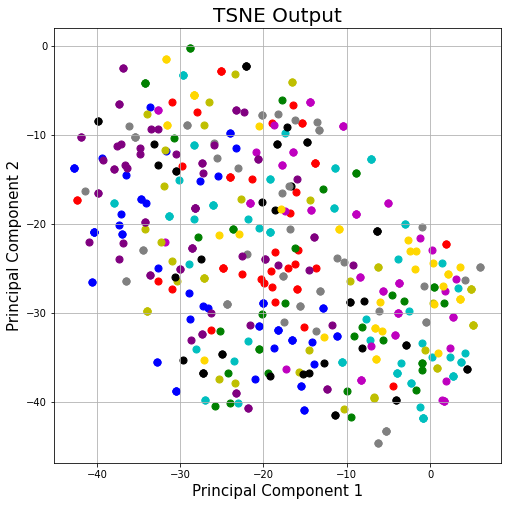

In [ ]:
##### Experiment PCA with 500 samples
# cnt = 0
# i=0
# tmp = [0 for i in range(128)]
# x = [tmp for i in range(1000)]
# vec_cnt = [0 for i in range(10)]

# model_ft.eval()

# while cnt < 500:

#     inputs, labels = next(iter(train_dataloader))
#     # print(labels)
    
#     for i in range(BATCH_SIZE):

#         if cnt == 500:
#             break
        
#         input = inputs[i].unsqueeze(0)
#         input = input.to(device)
#         vec = torch.squeeze(model_ft(input))
        
#         # print((labels[i]*100 + vec_cnt[labels[i]]))
#         x[(labels[i]*100 + vec_cnt[labels[i]])] = vec.detach().numpy()
#         vec_cnt[labels[i]] += 1
#         cnt += 1
#         i += 1

# x = StandardScaler().fit_transform(x)

# principalComponents = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 

# #plt.ylim([-30,30])

# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('TSNE Output', fontsize = 20)
# colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
# k=[0,2,6,8,9]
# x = 50
# for i in range(10):
#     ax.scatter(principalDf.loc[range((i*100),((i*100)+vec_cnt[i])), 'principal component 1']
#                , principalDf.loc[range((i*100),((i*100)+vec_cnt[i])), 'principal component 2']
#                , c = colors[i]
#                , s = 50)

# #ax.legend(targets)
# ax.grid()

In [ ]:
# print(vec_cnt) #Trial 3

[44, 37, 58, 68, 55, 41, 44, 36, 51, 66]


In [ ]:
# print(vec_cnt) #Trial 2

[29, 58, 62, 42, 67, 39, 59, 35, 69, 40]


In [ ]:
# print(vec_cnt) #Trial 1
# print(sum(vec_cnt))

[44, 46, 50, 47, 41, 56, 37, 66, 50, 63]
500


In [ ]:
# ##### PCA from trainloader
# cnt = 0
# i=0
# tmp = [0 for i in range(128)]
# x = [tmp for i in range(100)]
# vec_cnt = [0 for i in range(10)]

# model_ft.eval()

# while cnt < 100:

#     inputs, labels = next(iter(train_dataloader))
    
#     for i in range(BATCH_SIZE):
#         if vec_cnt[labels[i]] == 10:
#             i += 1
#             continue

#         if cnt == 100:
#             break
        
#         input = inputs[i].unsqueeze(0)
#         input = input.to(device)
#         vec = torch.squeeze(model_ft(input))
        
#         x[(labels[i]*10 + vec_cnt[labels[i]])] = vec.detach().numpy()
#         vec_cnt[labels[i]] += 1
#         cnt += 1
#         i += 1

In [ ]:
# ##### PCA from dataset directly
# cnt = 0
# i=0
# x = [[0] for i in range(100)]
# vec_cnt = [0 for i in range(10)]

# model_ft.eval()

# while cnt < 100:

#     input, label = training_data[i]

#     if vec_cnt[label] == 10:
#         i += 1
#         continue
    
#     input = input.unsqueeze(0)
#     input = input.to(device)
#     vec = torch.squeeze(model_ft(input))
    
#     x[(label*10 + vec_cnt[label])] = vec.detach().numpy()
#     vec_cnt[label] += 1
#     cnt += 1
#     i += 1

In [ ]:
# print(vec_cnt)
# # print(x)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [ ]:
# temp = []
# for i in range(100):
#     for j in range(128):
#         print(i, j)
#         temp.append(x[i][j])

#     x[i] = temp
#     temp = []

In [ ]:
# print(len(x))

100


In [ ]:
# x = StandardScaler().fit_transform(x)

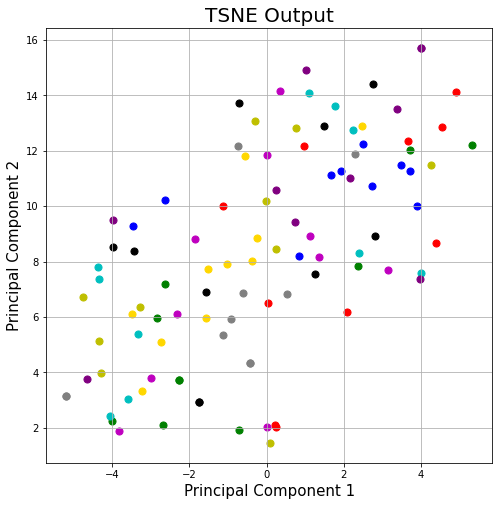

In [ ]:
# #### PCA
# # pca = PCA(n_components=2)
# # principalComponents = pca.fit_transform(x)
# # principalDf = pd.DataFrame(data = principalComponents
# #              , columns = ['principal component 1', 'principal component 2'])
# # fig = plt.figure(figsize = (8,8))
# # ax = fig.add_subplot(1,1,1) 
# # #plt.ylim([-30,30])
# # ax.set_xlabel('Principal Component 1', fontsize = 15)
# # ax.set_ylabel('Principal Component 2', fontsize = 15)
# # ax.set_title('PCA Output', fontsize = 20)
# # colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
# # k=[0,2,6,8,9]
# # x = 10
# # for i in range(10):
# #     ax.scatter(principalDf.loc[range((i*x),((i*x)+x)), 'principal component 1']
# #                , principalDf.loc[range((i*x),((i*x)+x)), 'principal component 2']
# #                , c = colors[i]
# #                , s = 50)
# # #ax.legend(targets)
# # ax.grid()


# #### TSNE
# principalComponents = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 

# #plt.ylim([-30,30])

# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('TSNE Output', fontsize = 20)
# colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
# k=[0,2,6,8,9]
# x = 10
# for i in range(10):
#     ax.scatter(principalDf.loc[range((i*x),((i*x)+x)), 'principal component 1']
#                , principalDf.loc[range((i*x),((i*x)+x)), 'principal component 2']
#                , c = colors[i]
#                , s = 50)

# #ax.legend(targets)
# ax.grid()

# Training
**torch.autograd.set_detect_anomaly(True)** was used to trace what part of the code was causing there to be Nan values.

**Error was traced to be:** RuntimeError: Function 'PowBackward0' returned nan values in its 0th output.

This error occurred even after we changed the model from ResNet to AlexNet. 

In [ ]:
torch.autograd.set_detect_anomaly(True)
train_model(model, train_dataloader, loss_fn, optimizer, lambd=5*1e-3, num_epochs=50) #labmd = 5*1e-3

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/data/weights_stl10_alexnet_self_supervised.pth')